# Gradient Descent

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2017 Winter Term 2

Mike Gelbart

In [18]:
import numpy as np
import numpy.random as npr
import sklearn
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 0

Autosave disabled


Learning goals:

- why do we need gradient descent? Can't we use the normal equations for everything?
- what is the step size? what role does it play?
- how do I implement gradient descent?
- what's the difference between the data space and the parameter space?

## Motivation 1: large-scale least squares

- Normal equations costs $O(nd^2 + d^3)$
- Can we do better for large $d$?

## Motivation 2: least squares with outliers

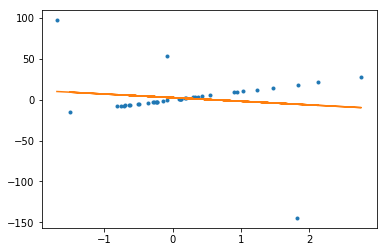

In [33]:
def gen_outlier_data(n=40,Noutliers=3):
    # generate random data
    x = np.random.randn(n)
    y = 10*x
    # add random outliers
    y[:Noutliers] = -100*(x[:Noutliers]+np.random.randn(Noutliers))

    X = x[:,None] # reshape for sklearn

    return X,y

# fit a linear regression model
X,y = gen_outlier_data()
lr = sklearn.linear_model.LinearRegression()
lr.fit(X,y)

plt.plot(X,y,'.')
plt.plot(X, lr.predict(X));

Can we do better?

## Gradient descent

#### use of the gradient: optimization

The gradient gives us the direction of fastest increase of a function with respect to its parameters.

The (negative) gradient gives us a direction of travel (fastest decrease), if we want to minimize a function!

If we are trying to minimize $f(w)$, then gradient descent works by starting with some initial guess $w^0$ and then updating with

$$w^{t+1} = w^t - \alpha^t\, \nabla f(w^t)$$

- $w^t$ refers to the value of $w$ (the weights/parameters) at iteration $t$ of gradient descent.
- Gradient descent is an algorithm for minimization. The corresponding method for maximization is called gradient ascent.
- The step size should be small to guarantee that the loss goes down. If it's too big the loss could go up.
- Converges to a global optimium if $f$ is convex. 
- (optional note): physicists like me tend to think about _units_. Note that $\nabla f$ and $w$ have different units, which means the learning rate has units. That seems weird, since we'd hope to pick the learning rate irrespective of the scaling of our probelm. If this bothers you, see [this blog post](http://timvieira.github.io/blog/post/2016/05/27/dimensional-analysis-of-gradient-ascent/) or the `findMin` function provided with a3.

- We can use this to minimize losses like the squared error (above) and robust losses (coming soon):


$$ f(w) = \sum_{i=1}^n\left(w^T x_i-y_i\right)^2 $$



#### magnitude vs. direction

In the above we are making use of the magnitude of the gradient, not just its direction. This actually makes sense. When the magnitude is small, we are in a flatter area and want to take smaller steps. 

However, some methods exist that just use the direction. For example given a direction you can do a [line search](https://en.wikipedia.org/wiki/Line_search).

#### picking the learning rate

In general picking $\alpha$ is a pain, especially when we get to stochastic gradient descent (later in the course). There is theory on this regarding convergence guarantees and convergence rates. The learning rate is sometimes decreased over time. Fancier methods pick the learning rate adaptively (see a3 code).

#### termination conditions

We can stop when $||\nabla f||$ is sufficiently small (because this indicates we're at a local minimum), or when a specified maximum number of iterations are reached (because we want to limit the computational expense).

## Least squares via normal equations vs. gradient descent:

- Normal equations cost $O(nd^2 + d^3)$.
  - forming $X^TX$ costs $O(nd^2)$ and solving a $d\times d$ linear system costs $O(d^3)$
- Gradient descent costs $O(ndt)$ to run for $t$ iterations.
  - computing $\nabla f(w)=X^TXw-X^Ty$ only costs $O(nd)$ 
- Gradient descent can be faster when $d$ is very large
  - well, this is just big-O, we don't know the coeffcients
  - matrix operations are fast. iteration is slow, especially in Python
  - assuming $t$ doesn't depend on $d$ (see CPSC 540)
  - one advantage is that we can control the accuracy by controlling the number of iterations

## Experiments: does it work?

In [34]:
# generate data
d = 10
n = 1000

X = npr.randn(n,d)
y = npr.randn(n)

#### Approach 1: sklearn's `LinearRegression` in Python

In [35]:
# sklearn least squares

lr = sklearn.linear_model.LinearRegression()
lr.fit(X,y)
print("Intercept: %f" % lr.intercept_)
print("Weights: %s" % lr.coef_)

Intercept: 0.026786
Weights: [ -7.94965323e-02  -6.89201836e-05  -5.68005257e-02   4.59495768e-02
   9.96527271e-04  -6.33594296e-04  -1.63302976e-02  -2.57339607e-02
   3.27755010e-02   3.44966248e-02]


**Approach 2: normal equations**

In [36]:
# add a feature of all 1's for intercept 
X = np.append(np.ones(X.shape[0])[:,None], X, axis=1)

In [37]:
weights = np.linalg.solve(X.T@X,X.T@y)

print("Intercept: %f" % weights[0])
print("Weights: %s" % weights[1:])

Intercept: 0.026786
Weights: [ -7.94965323e-02  -6.89201836e-05  -5.68005257e-02   4.59495768e-02
   9.96527271e-04  -6.33594296e-04  -1.63302976e-02  -2.57339607e-02
   3.27755010e-02   3.44966248e-02]


#### Approach 3: gradient descent

In [38]:
alpha = 0.00001

grad_f = lambda w: X.T@(X@w) - X.T@y

In [39]:
w = np.zeros(X.shape[1]) # initial guess

g = grad_f(w)
while np.linalg.norm(g) > 0.001:
    g = grad_f(w)
    
    w -= alpha*g
#     w = w - alpha*g
    
print("Intercept: %f" % w[0])
print("Weights: %s" % w[1:])

Intercept: 0.026785
Weights: [ -7.94961600e-02  -6.86061092e-05  -5.68001029e-02   4.59496352e-02
   9.96135548e-04  -6.33728601e-04  -1.63301708e-02  -2.57333259e-02
   3.27755459e-02   3.44961252e-02]


From the above, you can see that all three methods generate roughly the same weights. This is comforting.

## Robust regression with gradient descent

If we can solve least squares in closed form with linear algebra, why do we want gradient descent?

Answer: the fact that we can write the solution in closed form as a system of linear equations is amazing! (Think about it.) This is a very special case. For almost any other loss function, we can't do this.

For example let's consider the absolute value objective:

$$ f(w) = \sum_{i=1}^n\left|w^T x_i-y_i\right| $$

This is the sum of absolute values instead of the sum of squares. This will hopefully give us robust regression because big distances aren't amplified in the objective (let's dwell on this reasoning for a bit).

**Note on smoothness:** Non-smooth functions are harder to minimize than smooth functions. Unlike smooth functions, the gradient may not get smaller near a minimizer. 

Experiments below: this time we add outliers to mess up least squares, and then try switching to the absolute value objective. 

w = -6.621631
b = -15.276523


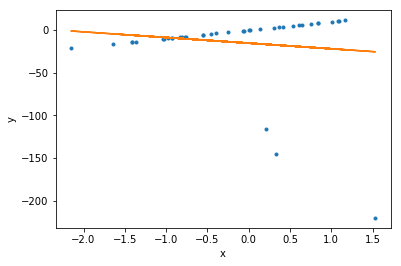

In [44]:
X,y = gen_outlier_data()
x = X.flatten()

# fit a linear regression model
lr = sklearn.linear_model.LinearRegression()
lr.fit(X,y)

print("w = %f" % lr.coef_)
print("b = %f" % lr.intercept_)

plt.plot(X,y,'.')
plt.plot(X, lr.predict(X))
plt.xlabel('x')
plt.ylabel('y');

For linear regression in one dimension our L1 objective becomes

$$f(w,\beta)=\displaystyle \sum_{i=1}^n\left|w x_i + \beta - y_i\right| $$

The gradient (where defined) is

$$\frac{\partial f}{\partial w} = \sum_{i=1}^n  x_i \textrm{sign}\left(w x_i + \beta - y_i\right)$$ 

$$\frac{\partial f}{\partial \beta} = \sum_{i=1}^n  \textrm{sign}\left(w x_i + \beta - y_i\right)$$ 



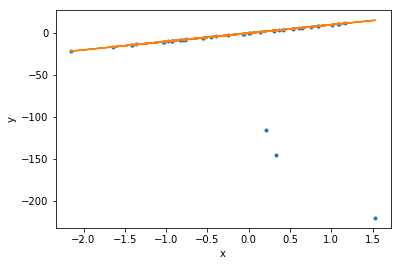

w = 10.013238
β = -0.011845


In [45]:
w = 0
β = 0
α = 1

Nsteps = 1000

for t in range(1,Nsteps):
    dLdw = np.sum(x*np.sign(w*x+β-y))
    dLdβ = np.sum(np.sign(w*x+β-y))
    w -= (α/t)*dLdw # we are decreasing the step size over time to deal with the non-smoothness
    β -= (α/t)*dLdβ # the details are beyond the scope of the course, see CPSC 540
    
plt.figure()
plt.plot(x,y,'.')
plt.plot(x,w*x+β)

plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("w = %f" % w)
print("β = %f" % β)


## Gradient descent is not just for robust regression!

We can use it for a large class of models. With some caveats, **you are now empowered to minimize things!** 

For example, one can try the opposite of robust regression, brittle regression, that just tries to minimize the maximum error. 

## Why gradient descent?

A common misconception from previous terms of CPSC 340:

> We use gradient descent because of the non-smooth loss.

Not true!! We use it because the normal equations only apply to linear least squares. We can use gradient descent in all sorts of cases. The non-smooth just complicates things a bit.

## Gradient descent is not the only game in town

There are many optimization algorithms out there. Gradient descent is not applicable in all contexts and it is certainly not the best method in all contexts! We focus on it because:

- it is relatively simple to understand and implement.
- the time complexity is linear in $d$ per iteration.
- we can generalize it to _stochastic gradient descent_, which is coming later in the course.
- see CPSC 406 for much more.

Through Python's scientific libraries like [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) you can access a variety of methods as black-box optimizers. For example see scipy's [implementation of the popular L-BFGS method](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_l_bfgs_b.html), which is more sophisticated but still linear in $d$ per iteration.

## The different decisions we make

We should try to keep separate (in our minds) the following choices:

- the model (e.g. linear)
- the loss (e.g. squared error)
- the optimization method (e.g. gradient descent)

We can (roughly) pick these independently of each other. Not quite because the choice of optimization method may depend on the choice of model/loss: e.g. we can use the normal equations as our optimization method if we're doing least squares.

## What space am I in?

A key skill is being able to move around (conceptually) between $x$ (data) space and $w$ (parameter) space. The above plots are in $y$ vs. $x$ space. Here's what the loss looks like in parameter space:

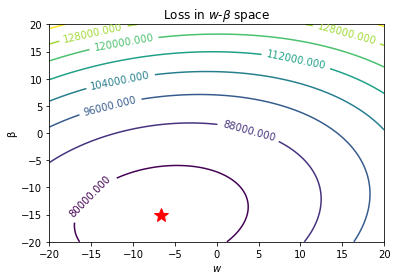

In [46]:
def plot_loss(loss_fun, X, y): # reading/understanding this plotting code is optional
    m = 100
    w_lin = np.linspace(-20.0, 20.0, m)
    b_lin = np.linspace(-20.0, 20.0, m)
    w_grid, b_grid = np.meshgrid(w_lin, b_lin)
    w_flat = w_grid.flatten()
    b_flat = b_grid.flatten()
    
    pred = w_flat[None]*X + b_flat[None]

    loss = loss_fun(pred, y) 
    loss_grid = np.reshape(loss,[m,m])

    plt.figure()
    CS = plt.contour(w_grid, b_grid, loss_grid)
    imin = np.argmin(loss_grid)
    plt.plot(w_flat[imin], b_flat[imin], 'r*', markersize=15)
    plt.xlabel('$w$')
    plt.ylabel('β')
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Loss in $w$-$β$ space')
    plt.show()
              
squared_loss_fun = lambda pred, y: np.sum((pred-y[:,None])**2,axis=0)
plot_loss(squared_loss_fun, X, y)

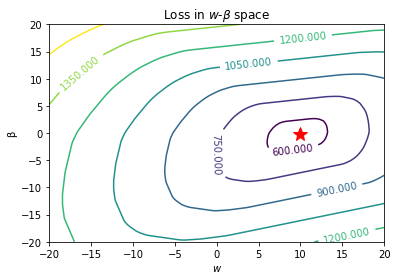

In [47]:
abs_loss_fun = lambda pred, y: np.sum(np.abs(pred-y[:,None]),axis=0)

plot_loss(abs_loss_fun, X, y)

Key intuition: every point in weight space corressponds to a _model_ (in this case a line) in input-output space.

- In general, doing supervised learning in $d$ dimensions, the data space will be mapping from $d$ dimensions to $1$ dimensional. 
- For linear models, the number of parameters is $d+1$ ($d$ weights plus an intercept), but this isn't necessarily the case for other models.

w = 2.987198
β = -8.984138


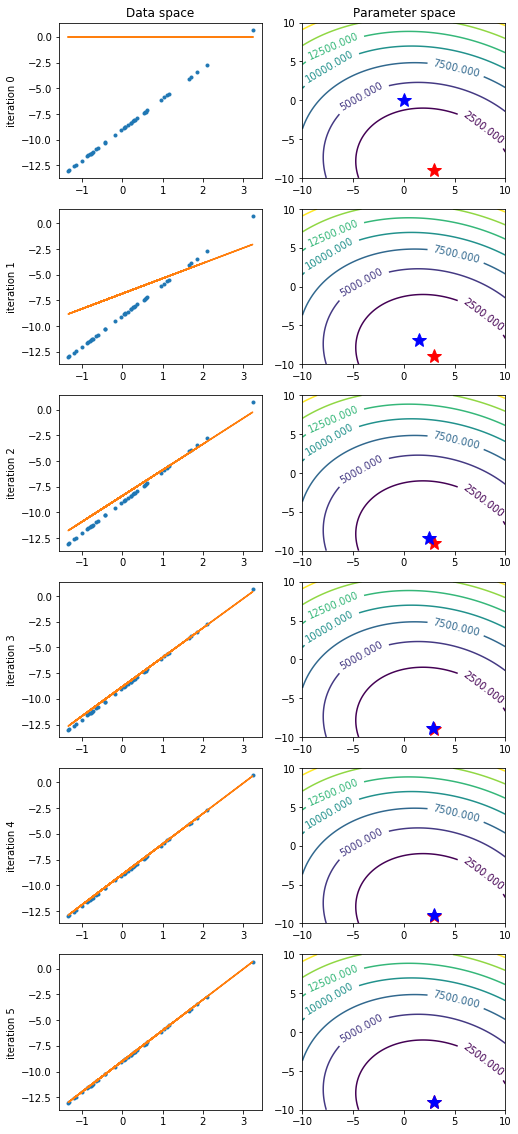

In [48]:
# a few iterations of GD showing the loss space and line space
# you don't need to read/understand this code (it's optional)

x = np.random.randn(40)
y = 3*x-9
X = x[:,None]

w = 0
β = 0
α = 0.02

Nsteps = 5

def make_plot_pairs(w,β,t,titles=False): 
    plt.subplot(Nsteps+1,2,2*t+1)    
    plt.plot(x,y,'.')
    plt.plot(x,w*x+β)
    plt.ylabel('iteration %d' % t)
    if titles:
        plt.title("Data space")
    
    plt.subplot(Nsteps+1,2,2*t+2)
    m = 100
    w_lin = np.linspace(-10.0, 10.0, m)
    β_lin = np.linspace(-10.0, 10.0, m)
    w_grid, β_grid = np.meshgrid(w_lin, β_lin)
    w_flat = w_grid.flatten()
    β_flat = β_grid.flatten()
    pred = w_flat[None]*X + β_flat[None]
    loss = squared_loss_fun(pred, y) 
    loss_grid = np.reshape(loss,[m,m])
    imin = np.argmin(loss_grid)
    plt.plot(w_flat[imin], β_flat[imin], 'r*', markersize=15)
    CS = plt.contour(w_grid, β_grid, loss_grid)
    plt.plot(w, β, 'b*', markersize=15)
    plt.clabel(CS, inline=1, fontsize=10)
    if titles:
        plt.title("Parameter space")

plt.figure(figsize=(8, 20))
make_plot_pairs(w,β,0,True)    
for t in range(Nsteps):
    dLdw = np.sum(x*(w*x+β-y))
    dLdβ = np.sum(w*x+β-y)
    w -= α*dLdw
    β -= α*dLdβ
    
    make_plot_pairs(w,β,t+1)

    
print("w = %f" % w)
print("β = %f" % β)

### Robust regression intuition (to read over later)

The loss is the sum of the absolute vertical distances between the points and the line. Let's assume you have 3 outliers all on the same side of the line, which are dragging the line up/down. Imagine shifting the line in towards the outliers by some small amount $\epsilon$. You have 3 points (the outliers) that are happier, meaning the loss goes down by $3\epsilon$. But, supposing there are 40 non-outlier points, you've upset those 40 points, meaning the loss goes up by $40 \epsilon$. So even moving the slightest bit upwards, or any amount for that matter, results in a worse (higher loss). That's why the robust fit is "perfect" rather than "close". You can think of it as voting and each point gets one vote; the outliers don't get more important votes than the non-outliers. So 40 beats 3. In real situations this reasoning doesn't apply exactly because the non-outliers will not lie perfectly on a line, and because you'll be in $d > 1$, but the general thought process applies.

We can go through the same thought experiment with least squares. If we move up by $\epsilon$ then the change in the loss function due to the outliers might be huge. For example if the outliers are currently 10 units away from the line and $\epsilon=1$ then we go from a loss of $10^2=100$ to $9^2=81$, so the loss decreases by 19 units for each outlier! Whereas for the non-outliers the loss increases from $0^2$ to $1^2$, and so the net increase is 1 unit of loss per point. Thus 3 outliers can actually overrule 40 non-outliers and the line starts to move. Until it reaches that equilibrium where the loss is minimized.

In fact, the above is an extension of the idea that the median of a bunch of numbers minimizes the L1 error and the mean minimizes the L2 error. The robustness of the median that we discussed early on in the course is this same effect. This is also related to $k$-means taking the mean and thus minimizing L2.

### Smooth approximations and the Huber loss

The absolute value loss is **non-smooth**. Although things above looked OK, in general it's not OK to naively ignore this issue (gradient descent will not asymptotically converge to the true solution, the above looks OK because we don't need a high accuracy solution). One way to avoid this issue is to use a **smooth approximation** to the loss. For example we can minimize the Huber objective

$$ \sum_{i=1}^n h \left( y_i-w^\top x_i\right) $$

where $$h(z) \equiv \begin{cases} 
      \frac{1}{2} z^2 & \textrm{if} \; |z|\leq 1 \\   |z|-\frac12 & \textrm{if} \; |z|>1
   \end{cases} $$

with gradient descent. This will hopefully give us robust regression because big distances aren't amplified in the objective.



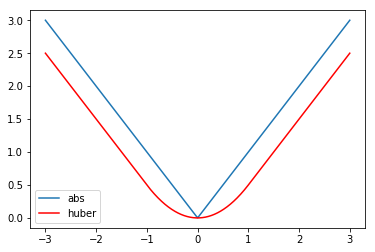

In [49]:
huber = lambda z: 0.5*z**2*(np.abs(z)<=1) + (np.abs(z)-0.5)*(np.abs(z)>1)

grid = np.linspace(-3,3,1000)
plt.plot(grid, np.abs(grid), label="abs")
plt.plot(grid, huber(grid), 'r', label="huber")
plt.legend()
plt.show()

For linear regression in one dimension our objective becomes

$$f(w,\beta)=\displaystyle \sum_{i=1}^n h\left(w x_i + \beta - y_i\right) $$

The gradient is

$$\frac{\partial f}{\partial w} = \sum_{i=1}^n  x_i h'\left( w x_i +\beta - y_i\right)$$ 

$$\frac{\partial f}{\partial \beta} = \sum_{i=1}^n  h'\left(w x_i +\beta - y_i\right)$$ 

where $$h'(z) = \begin{cases} 
       z & \textrm{if} \; |z|\leq 1 \\   \textrm{sign}(z) & \textrm{if} \; |z|>1
   \end{cases} $$

Minimizing this objective yields the robust fit, and in general is a very sensible thing to do!

w = 10.029835
b = -0.026649


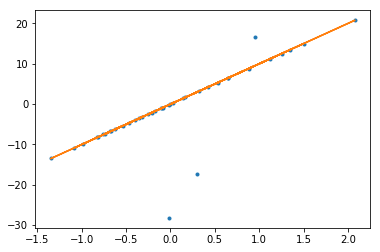

In [50]:
X,y = gen_outlier_data()
x=X.flatten()

w = 0
β = 0
α = 0.01

Nsteps = 1000
yhat = lambda x,w,b: w*x+b

huber_deriv = lambda z: z*(np.abs(z)<=1) + np.sign(z)*(np.abs(z)>1)

for t in range(Nsteps):
    dLdw = -np.sum(x*huber_deriv(y-yhat(x,w,β)))
    dLdβ = -np.sum(huber_deriv(y-yhat(x,w,β)))
    w -= α*dLdw
    β -= α*dLdβ
    
print("w = %f" % w)
print("b = %f" % β)

plt.plot(x,y,'.')
plt.plot(x,w*x+β);

## Log-sum-exp approximation (I bet I won't get to this in 50min)

For the brittle regression, discussed above, we can use the loss $f(w)=||Xw-y||_\infty$ where $||r||_\infty\equiv \max_i\{|r_i|\}$. A smooth approximation to the max function is 

$$\displaystyle \max_i\{z_i\} \approx \log \left(\sum_i \exp(z_i)\right)$$

- We will use this several times in the course, including in a3
- In a3 you use it as an approximation of $\max\{z,-z\}$ which is another way of writing $|z|$.
- The intuition is that the largest element is magnified exponentially, so we can roughly neglect the rest
  - This reduces it to $\log \left(\sum_i \exp(z_i)\right) \approx \log\left(\exp(\max_i\{z_i\})\right)=\max_i\{z_i\}$
- This approximation can be used for robust regression or brittle regression, but in very different ways. Take your time to understand the distinction here!

### Outliers in the features

We've been talking about "robust" regression with respect to strange values in $y$. But this can also happen in the features, $X$. Some of the methods in the Outlier Detection lecture apply, but in general we don't do a full treatment of this issue in CPSC 340. For more on this, see CPSC 540.

## Summary

- Gradient descent finds stationary point of differentiable function.
  - Finds global optimum if function is convex.
- Robust regression using L1-norm is less sensitive to outliers.
- Smooth approximations:
  - Let us apply gradient descent to non-smooth functions.
  - Huber loss is a smooth approximation to absolute value.
  - Log-Sum-Exp is a smooth approximation to maximum.